# 02 — Visual Study (BR1)

**Objective**  
Establish visual differentiations between healthy and mildew-infected cherry leaves.

**Inputs**  
- Dataset: `inputs/cherry_leaves_dataset/`  
  - Subfolders: `healthy/`, `powdery_mildew/`

**Outputs**  
- Exported figures for class average images, variability images, and difference maps.  
- Image montages per class.  
- Files saved under: `plots/v1/`

In [2]:
from pathlib import Path
import os

# Ensure working directory is project root so relative paths are stable
nb_cwd = Path.cwd()
project_root = nb_cwd if (nb_cwd / "inputs").exists() else nb_cwd.parent
os.chdir(project_root)

DATA_DIR = Path("inputs/cherry_leaves_dataset")
CLASSES = ("healthy", "powdery_mildew")
PLOTS_DIR = Path("plots") / "v1"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

print("CWD:", Path.cwd())
print("DATA_DIR:", DATA_DIR.resolve())
print("PLOTS_DIR:", PLOTS_DIR.resolve())
for cls in CLASSES:
    print(f"{cls:>16} ->", (DATA_DIR / cls).exists())

CWD: c:\Users\ksstr\Documents\Coding\milestone-project-5
DATA_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\inputs\cherry_leaves_dataset
PLOTS_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1
         healthy -> True
  powdery_mildew -> True


### Compute Average Image per Class
Each image is resized to 100×100 pixels and normalized to [0,1].  
We calculate the per-pixel mean across all images in each class to visualize typical leaf color and structure.

In [3]:
from PIL import Image
import numpy as np
from pathlib import Path

IMG_SIZE = (100, 100)
EXTS = (".jpg", ".jpeg", ".png", ".JPG", ".JPEG", ".PNG")

def load_images_to_array(folder: Path, img_size=IMG_SIZE) -> np.ndarray:
    """Load and normalize images of a given class folder into a numpy array [N, H, W, C]."""
    arrs = []
    for p in folder.iterdir():
        if p.is_file() and p.suffix in EXTS:
            with Image.open(p) as im:
                im = im.convert("RGB").resize(img_size)
                arr = np.asarray(im, dtype=np.float32) / 255.0  # normalize
                arrs.append(arr)
    if not arrs:
        return np.empty((0, img_size[1], img_size[0], 3), dtype=np.float32)
    return np.stack(arrs, axis=0)

avg_images = {}
counts = {}

for cls in CLASSES:
    cls_dir = DATA_DIR / cls
    imgs = load_images_to_array(cls_dir)
    counts[cls] = imgs.shape[0]
    if imgs.shape[0] == 0:
        print(f"No images found for class: {cls}")
        avg_images[cls] = None
        continue
    avg = imgs.mean(axis=0)  # pixel-wise mean
    avg_images[cls] = (avg * 255.0).clip(0, 255).astype(np.uint8)

counts

{'healthy': 2104, 'powdery_mildew': 2104}

### Visualize and Export Average Images
Display the class-wise average images and export them as PNG files  
for later use in the dashboard and README visual references.

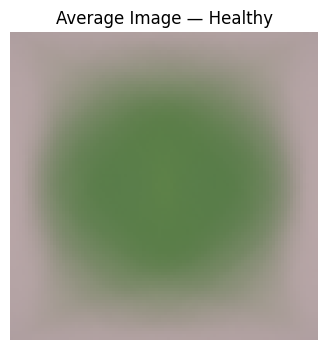

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1\avg_healthy.png


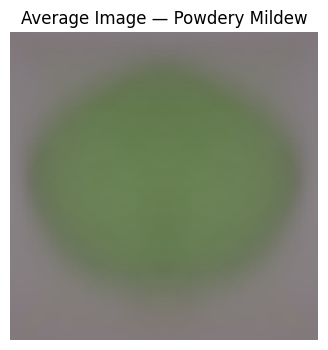

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1\avg_powdery_mildew.png


In [4]:
import matplotlib.pyplot as plt

for cls in CLASSES:
    avg = avg_images[cls]
    if avg is None:
        continue

    fig = plt.figure(figsize=(4, 4))
    plt.imshow(avg)
    plt.axis("off")
    plt.title(f"Average Image — {cls.replace('_', ' ').title()}")

    # Export figure to plots directory for later reuse
    out_path = PLOTS_DIR / f"avg_{cls}.png"
    fig.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.show()
    print(f"Saved: {out_path.resolve()}")

### Compute Variability (Per-Pixel Standard Deviation)
Images are resized to 100×100 and normalized to [0,1].  
For each class, the per-pixel standard deviation is computed to highlight regions with higher variability.

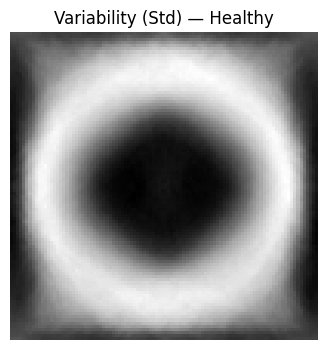

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1\var_healthy.png


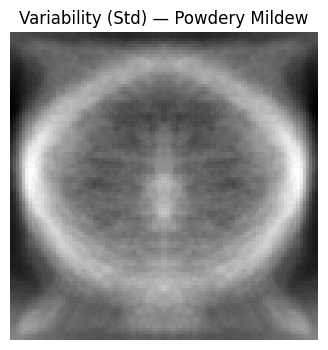

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1\var_powdery_mildew.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path

IMG_SIZE = (100, 100)
ALLOWED = {".jpg", ".jpeg", ".png"}

def load_stack(folder: Path, img_size=IMG_SIZE) -> np.ndarray:
    """Return image stack [N,H,W,C] in [0,1] for all valid files in folder."""
    arrs = []
    for p in folder.iterdir():
        if p.is_file() and p.suffix.lower() in ALLOWED:
            with Image.open(p) as im:
                im = im.convert("RGB").resize(img_size)
                arrs.append(np.asarray(im, dtype=np.float32) / 255.0)
    if not arrs:
        return np.empty((0, img_size[1], img_size[0], 3), dtype=np.float32)
    return np.stack(arrs, axis=0)

for cls in CLASSES:
    cls_dir = DATA_DIR / cls
    stack = load_stack(cls_dir)
    if stack.shape[0] == 0:
        print(f"No images found for class: {cls}")
        continue

    # Pixel-wise std across images -> [H,W,C]
    std_rgb = stack.std(axis=0)

    # Collapse channels to a single map for clearer inspection -> [H,W]
    std_gray = std_rgb.mean(axis=2)

    # Scale to [0,255] for saving
    s = std_gray
    s_min, s_max = float(s.min()), float(s.max())
    s_scaled = (255.0 * (s - s_min) / (s_max - s_min + 1e-8)).astype(np.uint8)

    # Visualize and export
    fig = plt.figure(figsize=(4, 4))
    plt.imshow(s_scaled, cmap="gray")
    plt.axis("off")
    plt.title(f"Variability (Std) — {cls.replace('_', ' ').title()}")

    out_path = PLOTS_DIR / f"var_{cls}.png"
    fig.savefig(out_path, bbox_inches="tight", pad_inches=0)
    plt.show()
    plt.close(fig)
    print(f"Saved: {out_path.resolve()}")

### Compute Class Difference Map (Average Healthy − Average Mildew)
Class-wise average RGB images are subtracted to highlight systematic differences.  
We show the absolute difference (grayscale) and export the figure for later use.

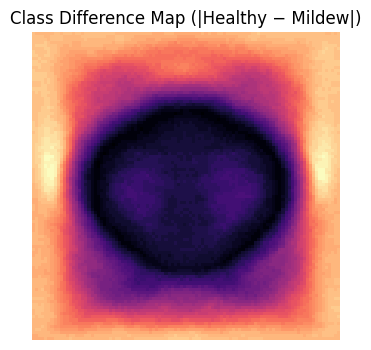

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1\diff_classes.png


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Helper: load a precomputed average image if present on disk, else compute from stack
def compute_average(folder: Path, img_size=(100, 100)) -> np.ndarray:
    arrs = []
    for p in folder.iterdir():
        if p.is_file() and p.suffix.lower() in {".jpg", ".jpeg", ".png"}:
            with Image.open(p) as im:
                im = im.convert("RGB").resize(img_size)
                arrs.append(np.asarray(im, dtype=np.float32) / 255.0)
    if not arrs:
        return np.zeros((img_size[1], img_size[0], 3), dtype=np.float32)
    return np.stack(arrs, axis=0).mean(axis=0)  # [H,W,C] in [0,1]

# Ensure we have average arrays in [0,1]
avg_h = (avg_images["healthy"].astype(np.float32) / 255.0
         if "healthy" in avg_images and avg_images["healthy"] is not None
         else compute_average(DATA_DIR / "healthy", IMG_SIZE))
avg_m = (avg_images["powdery_mildew"].astype(np.float32) / 255.0
         if "powdery_mildew" in avg_images and avg_images["powdery_mildew"] is not None
         else compute_average(DATA_DIR / "powdery_mildew", IMG_SIZE))

# Absolute difference collapsed to grayscale for clarity
diff = np.abs(avg_h - avg_m).mean(axis=2)  # [H,W] in [0,1]
diff_img = (diff * 255.0).clip(0, 255).astype(np.uint8)

fig = plt.figure(figsize=(4, 4))
plt.imshow(diff_img, cmap="magma")  # high-contrast colormap for differences
plt.axis("off")
plt.title("Class Difference Map (|Healthy − Mildew|)")
out_path = PLOTS_DIR / "diff_classes.png"
fig.savefig(out_path, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close(fig)
print(f"Saved: {out_path.resolve()}")